In [334]:
import torch
import torchvision 
import os
import matplotlib.pyplot as plt

## Dataset Link: https://www.kaggle.com/vipoooool/new-plant-diseases-dataset

In [335]:
train_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_path = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_path = '../input/new-plant-diseases-dataset/test'

In [336]:
print(os.path.exists(train_path))
print(os.path.exists(val_path))
print(os.path.exists(test_path))

True
True
True


In [337]:
for i in os.listdir(train_path):
    print(i)

Tomato___Target_Spot
Tomato___Early_blight
Apple___healthy
Tomato___healthy
Blueberry___healthy
Grape___healthy
Peach___healthy
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Tomato___Leaf_Mold
Apple___Black_rot
Squash___Powdery_mildew
Corn_(maize)___Northern_Leaf_Blight
Strawberry___Leaf_scorch
Pepper,_bell___healthy
Orange___Haunglongbing_(Citrus_greening)
Potato___Late_blight
Tomato___Late_blight
Strawberry___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Raspberry___healthy
Tomato___Tomato_mosaic_virus
Tomato___Spider_mites Two-spotted_spider_mite
Pepper,_bell___Bacterial_spot
Cherry_(including_sour)___healthy
Tomato___Septoria_leaf_spot
Peach___Bacterial_spot
Apple___Cedar_apple_rust
Tomato___Bacterial_spot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Apple___Apple_scab
Grape___Black_rot
Potato___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___healthy
Potato___Early_blight
Soybean___healthy


In [338]:
import torchvision.transforms as tt

In [339]:
train_tfms = tt.Compose([tt.Resize(128), 
#     tt.CenterCrop(100), 
#     tt.ColorJitter(brightness=0.5),
#     tt.RandomCrop(128, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(), 
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_tfms = tt.Compose([tt.Resize(128),
                       tt.ToTensor(),
                       tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                     ])

In [340]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [341]:
train_ds = ImageFolder(train_path, train_tfms)
val_ds = ImageFolder(val_path, val_tfms)

In [342]:
batch_size = 32

In [343]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_path, batch_size, num_workers=4, pin_memory=True)

In [344]:
from torchvision.utils import make_grid

In [345]:
def show_batch(dl):
    for images, labels in dl:
        plt.figure(figsize=(16,8))
        print("images.shape :", images.size)
        plt.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break

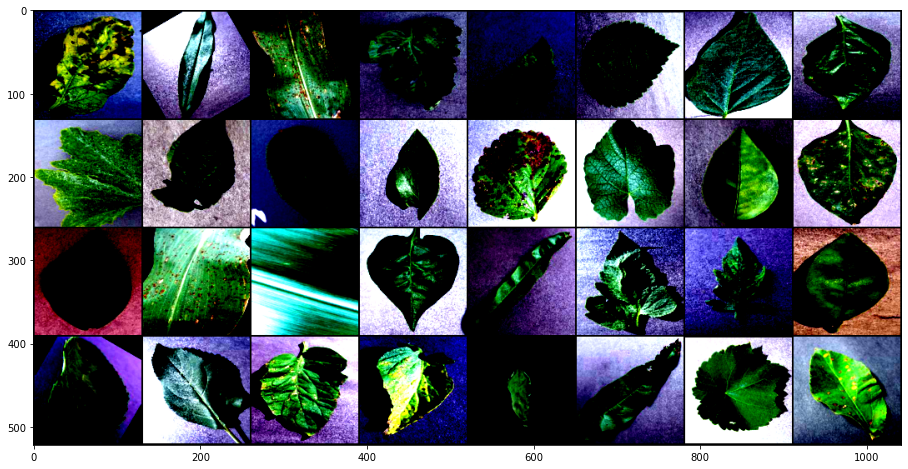

In [346]:
show_images(train_dl)

In [347]:
project_name = "recognition-plant-diseases-by-leaf"

In [348]:
pip install jovian

Note: you may need to restart the kernel to use updated packages.


In [349]:
import jovian

In [350]:
def get_device():
    if torch.cuda.is_available():
        print("cuda")
    else:
        print("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return to_device(data, device)
    return data.to(device, non_blocking=True)

class DataDeviceLoader():
    def __init__(self, device, dl):
        self.dl = dl
        self.device = device
        
        def __iter__(self):
            for data in self.dl:
                yield to_device(data, self.device)
        
        def __len__(self):
            return len(self.dl)

In [351]:
device = get_device()
device

cuda


In [352]:
train_dl = DataDeviceLoader(train_dl, device)
val_dl = DataDeviceLoader(val_dl, device)

In [353]:
import torch.nn as nn
import torch.nn.functional as F

In [354]:
def accuracy(outputs, labels):
    _, preds = torch.ma(outputs, dim=1)
    return torch.tensor(torch.sum(pres == labels) / len(preds))

class ImageClass(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out,labels)
        return {'val_loss ': loss.detach(), 'val_acc ': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        val_losses = torch.stack(batch_losses).mean()
        batch_accs = [x['va_acc'] for x in outputs]
        val_accs = torch.stack(batch_accs).mean()
        return {'val_loss ': val_losses, 'val_acc ': val_accs}
    
    def epoch_end(self, epochs, result):
        print("Epoch [{}], train_loss : {:.4f}, val_loss : {:.4f}, val_acc : {:.4f}".format(
            epochs, result['train_loss'], result['val_loss'], result['val_acc']))

# **Simple Model**

In [355]:
class Model(ImageClass):
    def __init__(self):
        super().__init__()
        self.model = nn.Linear(49152, 38)
        
    def forward(self, input):
        out = self(input)
        return out

In [356]:
model1 = Model()

In [357]:
model1 = to_device(model1, device)
model1

Model(
  (model): Linear(in_features=49152, out_features=38, bias=True)
)

# **NN Model**

In [358]:
class NNModel(ImageClass):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(49152, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, 38)
    
    def forward(self, input):
        out = self.layer1(input)
        out = nn.ReLU(out)
        out = self.layer2(out)
        out = nn.ReLU(out)
        out = nn.layer3(out)
        return out

In [359]:
model2 = NNModel()

In [360]:
model2 = to_device(model2, device)
model2

NNModel(
  (layer1): Linear(in_features=49152, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=38, bias=True)
)

# **CNN Model Using BatchNorm**

In [361]:
class CNNModel(ImageClass):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
        )
        self.classifier =  nn.Sequential(
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128, 38)
        )

def forward(self, input):
    out = self.model(input)
    out = self.classifier(out)
    return out

In [362]:
model3 = CNNModel()

In [363]:
model3 = to_device(model3, device)
model3

CNNModel(
  (model): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Flatten()
    (2): Linear(in_features=128, out_features=38, bias=True)
  )
)

In [369]:
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    outputs = model.validation_step(dl)
    return model.validation_epoch_end(outputs)

def fit(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None, optim_func=torch.optim.Adam):
    history = []
    train_loss = []
    optimizer = optim_func(model.parameters(), max_lr, weight_decay=weight_decay)
    lr_sch = torch.optim.lr_scheduler.OneCycleLR(optimizer, weight_decay, epochs, steps_per_epoch=len(train_dl))
    
    for epoch in epochs:
        model.train()
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                torch.nn.grad_clip(model.parameters(), grad_clip=grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lr_sch.step()
        
        result = model.evaluate(val_dl)
        result.append(train_loss)
        model.epoch_end(epoch, result)
        history.append(result)
    return history